In [38]:
import sys; sys.path.append("../../")
from DataPreprocessing.DataPreprocessing import *
from DataExploration.DataExploration import *
from utils import *
import matplotlib.pyplot as plt
import sklearn.metrics as sm
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Question:
    For each genre, Will its sales increase over upcoming years?

##  Expectations: 
    genre that has high sales over previous years, its sales will increase over upcoming years unless
    there's a great drop at some year may affect the upcoming sales.

## Read Data 

In [39]:
# read the data
df=read_data(kind='all')
#drop the null values
df = df.dropna()
#drop years  after 2003
df = df[df['Year_of_Release'] < 2005]
#select the columns
selected_cols=[ 'Genre', 'Year_of_Release',  'Global_Sales']
df = df[selected_cols]
df.head(11)

,Genre,Year_of_Release,Global_Sales
17,Action,2004.0,20.81
24,Action,2002.0,16.15
28,Racing,2001.0,14.98
38,Action,2001.0,13.10
48,Racing,2004.0,11.66
52,Racing,1997.0,10.95
65,Role-Playing,1997.0,9.72
67,Racing,1999.0,9.49
78,Shooter,2004.0,8.49
84,Role-Playing,2001.0,8.05


## Prepare Data for all genre

In [40]:
df_all_genre=[] #list of dataframes for each genre
genres = df['Genre'].unique()
for i, genre in  enumerate(genres):
    print(i, genre)
    df_all_genre.append( df[df['Genre'] ==genre])


0 Action
1 Racing
2 Role-Playing
3 Shooter
4 Fighting
5 Platform
6 Sports
7 Misc
8 Simulation
9 Puzzle
10 Adventure
11 Strategy


In [42]:
df[df['Genre'] == 'Action'].head()

,Genre,Year_of_Release,Global_Sales
17,Action,2004.0,20.81
24,Action,2002.0,16.15
38,Action,2001.0,13.10
139,Action,1999.0,6.27
144,Action,2001.0,6.05


In [43]:
# drop genre column
for i, genre in  enumerate(df_all_genre):
    df_all_genre[i] = df_all_genre[i].drop('Genre', axis=1)
df_all_genre[0].head()

,Year_of_Release,Global_Sales
17,2004.0,20.81
24,2002.0,16.15
38,2001.0,13.10
139,1999.0,6.27
144,2001.0,6.05


## Group sales of the same genre at the same year

In [44]:
for i, genre in  enumerate(df_all_genre):
    # group by year and sum global sales
    df_all_genre[i] = df_all_genre[i].groupby('Year_of_Release', as_index=False).sum()

df_all_genre[0].head()

,Year_of_Release,Global_Sales
0,1996.0,10.71
1,1997.0,1.99
2,1998.0,15.27
3,1999.0,9.38
4,2000.0,15.40


# EDA

## Global sales VS years for each genre

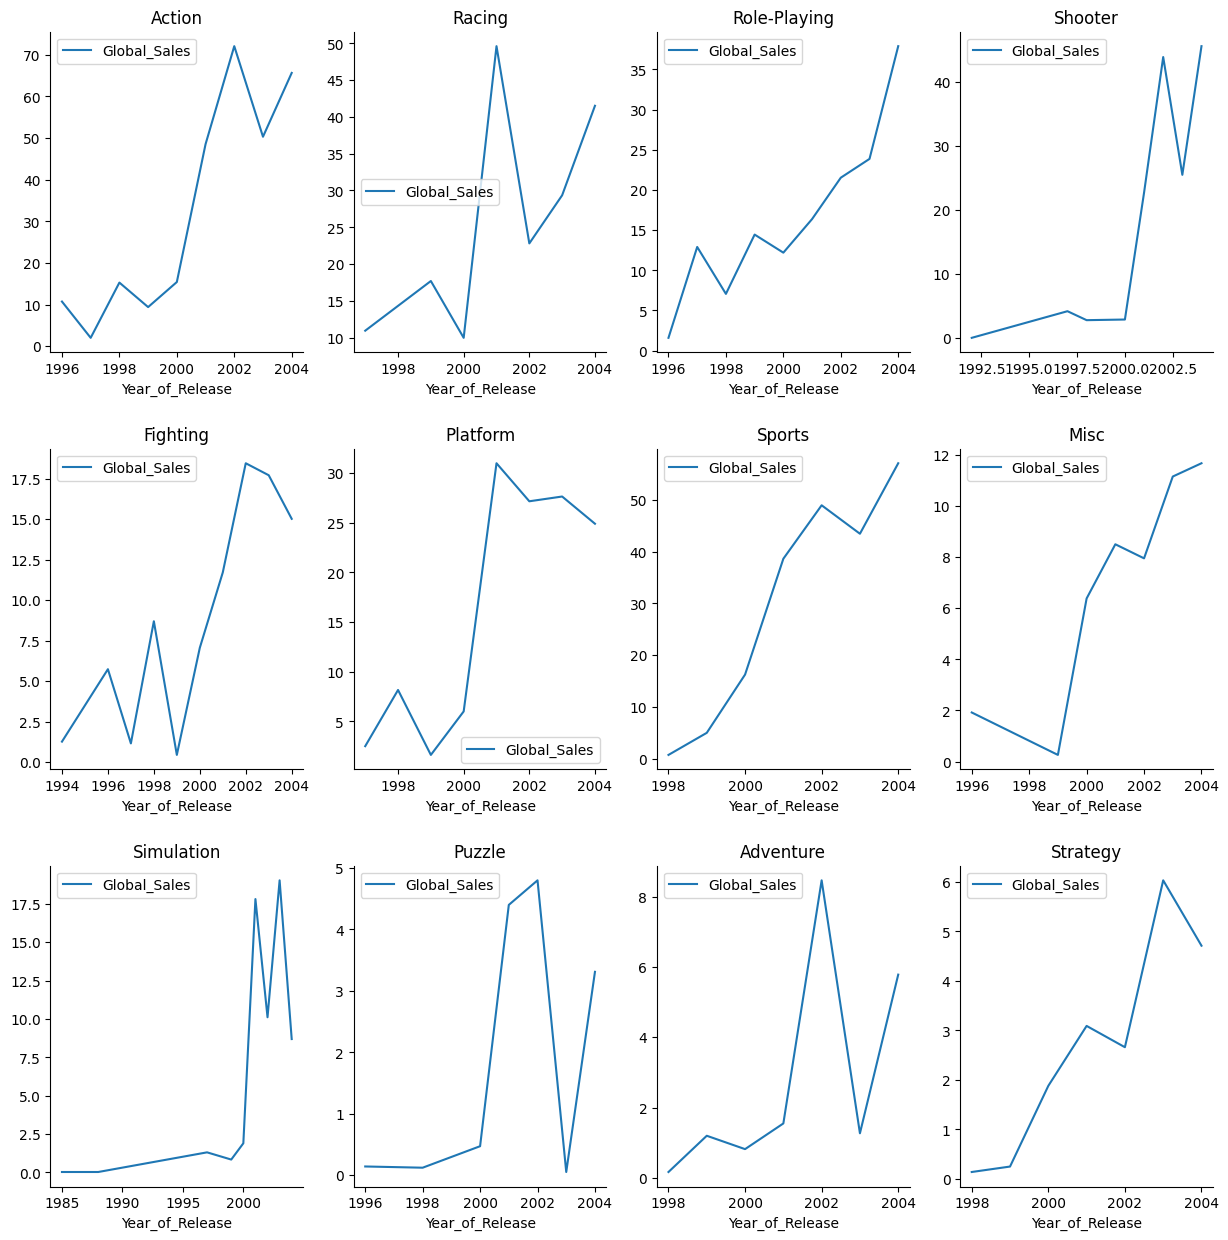

In [48]:
# for all genres, plot global sales vs year in different subplots in one figure
fig, axes = plt.subplots(3,4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3)
sns.despine(left=False, bottom=False)
for i in  range(len(df_all_genre)):
    df_all_genre[i].plot(x='Year_of_Release', y='Global_Sales', ax=axes[i//4, i%4], title=genres[i])
    #make legend best location
    plt.legend(['Global_Sales'], loc='best')

    
plt.show()

## Results
- Action, Racing, sports, role playing, shooting, puzzle and adventure sales are increasing.
- Simulation, strategy and fighting sales are decreasing.

## Time Series Prediction

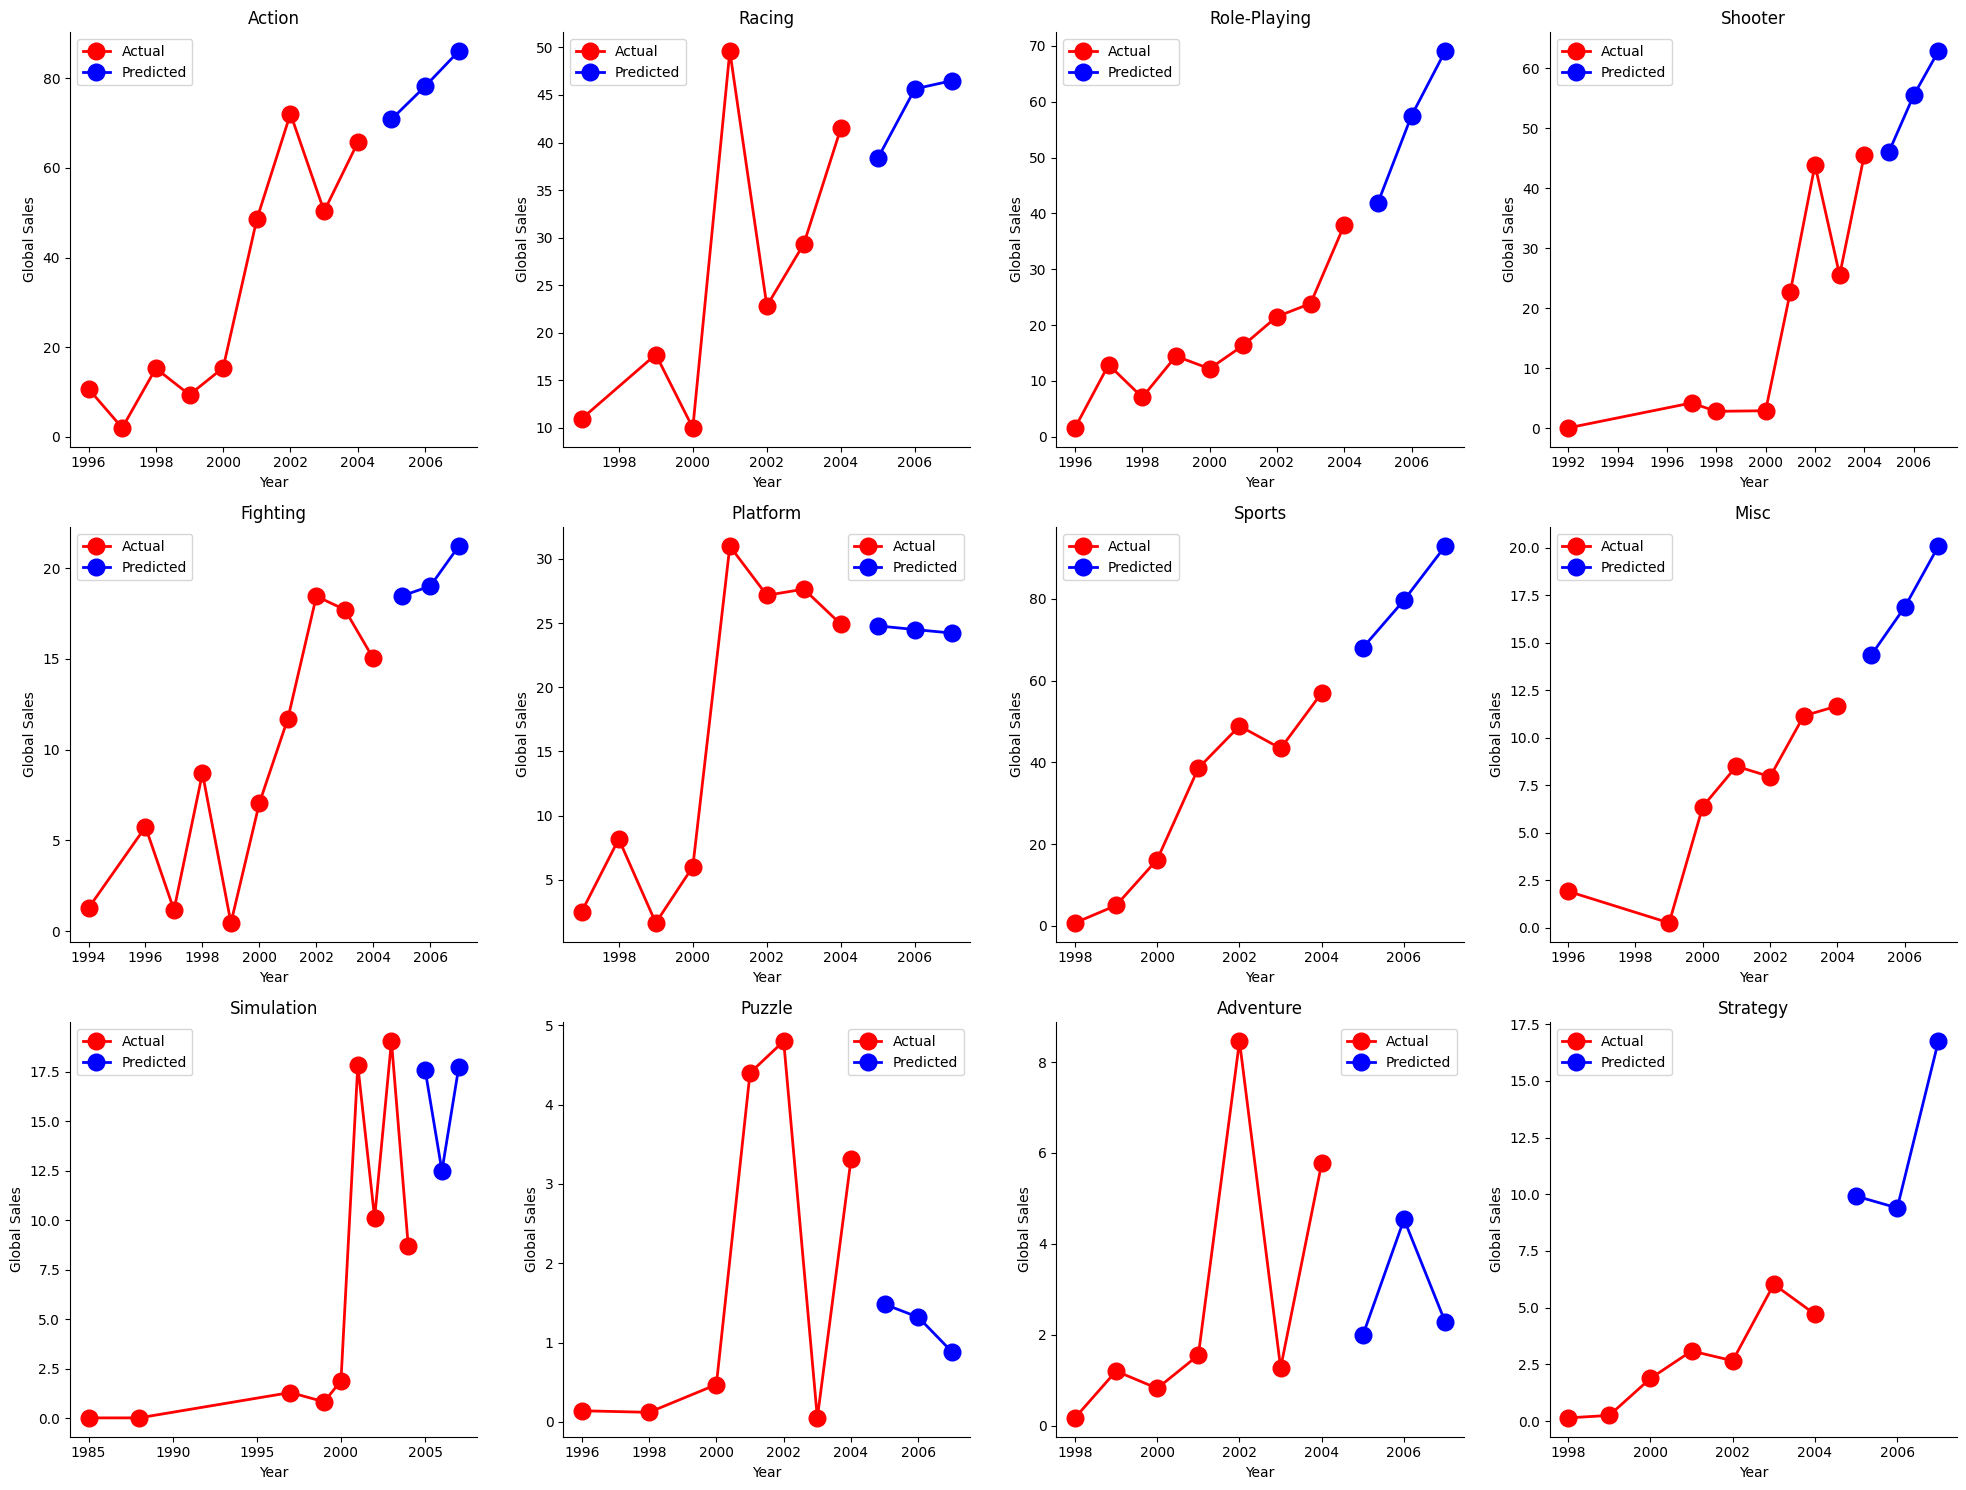

In [47]:
steps_to_predict = 3
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
sns.despine(left=False, bottom=False)

for i in range(3):
    for j in range(4):
        idx = i * 4 + j
        if idx >= (len(df_all_genre)):
            break
        model = sm.tsa.statespace.SARIMAX(endog=df_all_genre[idx]['Global_Sales'], order=(2, 0, 0), enforce_stationarity=False)
        sarima = model.fit()
        ax = axs[i, j]
        ax.set_title(genres[idx])
        # Convert Year_of_Release to int
        df_all_genre[idx]['Year_of_Release'] = df_all_genre[idx]['Year_of_Release'].astype(int)
        years = list(df_all_genre[idx]['Year_of_Release'].unique())
        # Get predicted years
        years_to_predict = list(range(years[-1] + 1, years[-1] + steps_to_predict + 1))
        ax.plot(years, df_all_genre[idx]['Global_Sales'], "ro-", linewidth=2, markersize=12)
        ax.plot(years_to_predict, sarima.forecast(steps_to_predict), "bo-", linewidth=2, markersize=12)
        ax.set_xlabel("Year")
        ax.set_ylabel("Global Sales")
        ax.legend(['Actual', 'Predicted'], loc='best')

plt.subplots_adjust(wspace=0.9)
plt.tight_layout()
plt.show()

## Results
- For the next 3 years the model predictions are:
    - Action, Racing, sports, role playing, shooting sales will keep increasing.
    - puzzle genre sales will decrease, that's because it has a great drop in its sales in 2002
    - adventure genre sales will increase in the first year then decreases as it has great drop also in 2002.
    - Simulation sales will decrease in the first year, then decrease. because of the significant increase in 2000. 
    - Fighting genre same as simulation will increase but its peak was from 2000 to 2002.
- So, Data matches the expectations